# NLP Disaster Tweets Kaggle Mini-Project

Plan:
- EDA
- Data Preprocessing
  - Tokenization
  - Stopword Removal
  - (some other stuff based on EDA)
  - Lemmatization
  - Vectorization
- Model Training
  - Baseline Model (Vanilla RNN)
  - LSTM
  - GRU (Maybe)
  - Fine-tuning (pre-trained embeddings, hyperparameter tuning)?
  - (maybe some transformer model if time permits)
- Model Evaluation
  - Accuracy
  - Precision, Recall, F1-Score
  - Confusion Matrix
- Conclusion and Future Work

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from cleantext import clean
import html

In [3]:
DATA_DIR = "./data"
SEED = 42

## EDA

In [4]:
df = pd.read_csv(f"{DATA_DIR}/train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


Positive samples: 3271
Negative samples: 4342


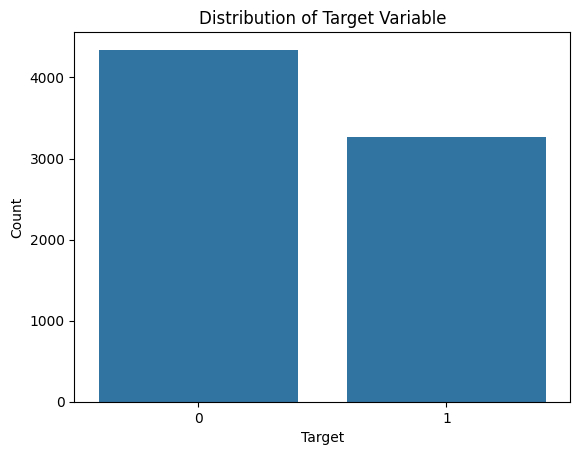

In [7]:
positive = df[df['target'] == 1]
negative = df[df['target'] == 0]
print(f"Positive samples: {len(positive)}")
print(f"Negative samples: {len(negative)}")

# plot the distribution of target variable
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [ ]:
duplicated_rows = df.duplicated()

duplicates_texts = df.duplicated(subset=["text"])

print(f"Duplicate tweets: {duplicates_texts.sum()}, duplicated rows: {duplicated_rows.sum()}")


Duplicate tweets: 110, duplicated rows: 0


In [21]:
df.duplicated(subset=["text"]).groupby(df['target']).sum()

target
0    37
1    73
dtype: int64

In [24]:
df[df["id"].isin(df[duplicates_texts]["id"])].sort_values("text")

,id,keyword,location,text,target
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
...,...,...,...,...,...
3461,4952,exploded,NaN,that exploded &amp; brought about the\nbeginni...,0
6103,8714,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6094,8702,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve be...,1


## Data Preprocessing


In [58]:
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")

In [66]:
MENTION_RE = re.compile(r'@\w+')
HASHTAG_RE = re.compile(r'#(\w+)')
RT_RE = re.compile(r'\brt\b', flags=re.IGNORECASE)

def clean_tweet(text):
    s = "" if text is None else str(text)
    # decode HTML entities
    s = html.unescape(s)

    # 2) general cleanup using clean-text library (lower, urls, emails, emoji, punctuation, line breaks, currency)
    s = clean(
        s,
        lower=True,
        no_urls=True,
        no_emails=True,
        fix_unicode=True,
        no_emoji=True,
        no_line_breaks=True,
        no_currency_symbols=True,
        no_punct=True,
        replace_with_url="",
        replace_with_email=""
    )

    # 3) tweet-specific rules
    s = MENTION_RE.sub("", s)         # remove @mentions
    s = HASHTAG_RE.sub(r"\1", s)      # keep hashtag word, drop '#'
    s = RT_RE.sub("", s)              # remove RT token

    # 4) normalize whitespace
    s = " ".join(s.split())
    return s

train_df['cleaned_text'] = train_df['text'].apply(clean_tweet)


In [68]:
print(train_df[train_df['id'] == 9278]['text'].values[0])
print("-----")
print(train_df[train_df['id'] == 9278]['cleaned_text'].values[0])

&lt;&lt; his lip as he sunk into the bed his arms crossed behind his head as he watched his Captain do a number on his body. @ResoluteShield
-----
<< his lip as he sunk into the bed his arms crossed behind his head as he watched his captain do a number on his body resoluteshield


## Tokenization